# AI-Powered Housing Affordability Prototype (With Generative AI)

This notebook demonstrates a generative AI-assisted implementation of a housing price prediction and affordability scoring system for Canadian properties. 

**Features:**
- Predict housing prices using ML
- Assess affordability based on median income
- Incorporate generative AI tools for preprocessing, pipeline generation, and scenario simulation
- Visualize results in a user-friendly format


## 1️⃣ Imports & Setup

We import all necessary libraries. Generative AI tools like ChatGPT or Copilot can assist in suggesting these imports and pipeline structure.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



## 2️⃣ Load Dataset

Load the housing dataset (`canadian_housing_data.csv`) and regional income dataset (`median_income.csv`). 

Generative AI can help generate code to automatically merge datasets and identify key features.


In [2]:
# Housing dataset
housing_df = pd.read_csv("canadian_housing_data.csv")

# Median income dictionary
median_income = {
    "Toronto": 100000,
    "Vancouver": 88000,
    "Montreal": 82000,
    "Ottawa": 95000,
    "Calgary": 97000
}

# Merge median income
housing_df['Median_Income'] = housing_df['City'].map(median_income)

housing_df.head()


,City,Province,Latitude,Longitude,Price,Bedrooms,Bathrooms,Acreage,Property Type,Square Footage,...,Fireplace,Heating,Flooring,Roof,Waterfront,Sewer,Pool,Garden,Balcony,Median_Income
0,Revelstoke,BC,50.976585,-118.173149,839000.0,3.0,2.0,0.00,Condo,891.0,...,No,heat pump,carpet,NaN,No,municipal,No,No,No,NaN
1,Boswell,BC,49.471870,-116.770195,1150000.0,3.0,2.0,0.32,Single Family,1881.0,...,No,heat pump,NaN,NaN,No,septic,No,No,No,NaN
2,West Kelowna,BC,49.825230,-119.603253,149000.0,2.0,1.0,0.00,Single Family,912.0,...,No,NaN,laminate,tar,No,municipal,No,No,No,NaN
3,Kelowna,BC,49.821860,-119.480143,1298000.0,5.0,4.0,0.69,Single Family,4374.0,...,Yes,forced air,NaN,NaN,No,municipal,No,No,No,NaN
4,Maple Ridge,BC,49.221673,-122.596637,759900.0,3.0,2.0,0.00,Condo,1254.0,...,No,radiant,NaN,NaN,No,none,No,No,No,NaN


## 3️⃣ Exploratory Data Analysis (EDA)

Visualize distributions and relationships. Generative AI can suggest plots or highlight important correlations.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44896 entries, 0 to 44895
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   City            44896 non-null  object 
 1   Province        44896 non-null  object 
 2   Latitude        44896 non-null  float64
 3   Longitude       44896 non-null  float64
 4   Price           44896 non-null  float64
 5   Bedrooms        44896 non-null  float64
 6   Bathrooms       44896 non-null  float64
 7   Acreage         44896 non-null  float64
 8   Property Type   44896 non-null  object 
 9   Square Footage  44896 non-null  float64
 10  Garage          44896 non-null  object 
 11  Parking         44896 non-null  object 
 12  Basement        14962 non-null  object 
 13  Exterior        17439 non-null  object 
 14  Fireplace       44896 non-null  object 
 15  Heating         38242 non-null  object 
 16  Flooring        15216 non-null  object 
 17  Roof            10052 non-null 

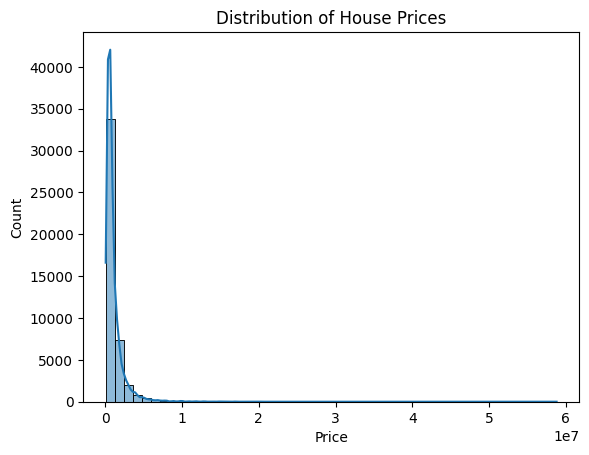

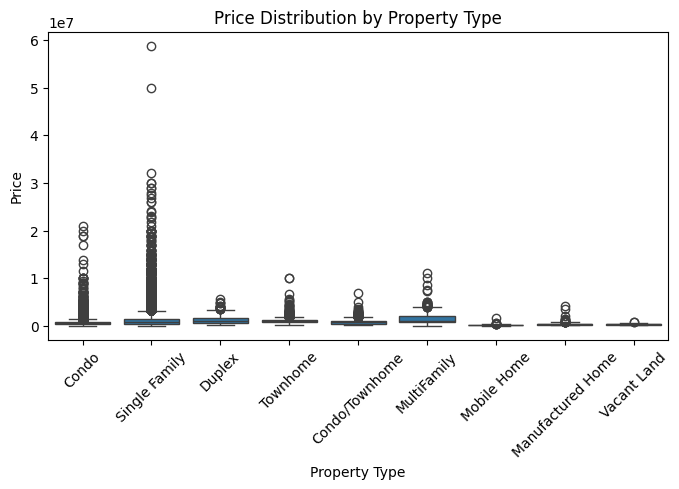

In [3]:
# Quick info
housing_df.info()
housing_df.describe()

# Price distribution
sns.histplot(housing_df['Price'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.show()

# Price by Property Type
plt.figure(figsize=(8,4))
sns.boxplot(x='Property Type', y='Price', data=housing_df)
plt.xticks(rotation=45)
plt.title("Price Distribution by Property Type")
plt.show()


## 4️⃣ Data Cleaning & Feature Engineering

Generative AI tools can suggest how to handle missing values, encode categorical features, and create new features.


In [4]:
# Fill missing values
housing_df['Price'].fillna(housing_df['Price'].median(), inplace=True)
housing_df['Bedrooms'].fillna(housing_df['Bedrooms'].median(), inplace=True)
housing_df['Bathrooms'].fillna(housing_df['Bathrooms'].median(), inplace=True)
housing_df['Acreage'].fillna(housing_df['Acreage'].median(), inplace=True)
housing_df['Square Footage'].fillna(housing_df['Square Footage'].median(), inplace=True)
housing_df['Property Type'].fillna('Unknown', inplace=True)
housing_df['City'].fillna('Unknown', inplace=True)
housing_df['Province'].fillna('Unknown', inplace=True)

# Feature engineering
housing_df['Price_per_sqft'] = housing_df['Price'] / housing_df['Square Footage']
housing_df['Bed_Bath_Ratio'] = housing_df['Bedrooms'] / (housing_df['Bathrooms'] + 1e-5)


C:\Users\singh\AppData\Local\Temp\ipykernel_20424\349944757.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_df['Price'].fillna(housing_df['Price'].median(), inplace=True)
C:\Users\singh\AppData\Local\Temp\ipykernel_20424\349944757.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

## 5️⃣ Train/Validation/Test Split (80/10/10)

We split the data into training, validation, and test sets. Generative AI can suggest best practices for splitting.


In [5]:
features = ['City', 'Province', 'Property Type', 'Latitude', 'Longitude',
            'Bedrooms', 'Bathrooms', 'Acreage', 'Square Footage',
            'Price_per_sqft', 'Bed_Bath_Ratio']
target = 'Price'

# Train/temp split
X_train, X_temp, y_train, y_temp = train_test_split(housing_df[features], housing_df[target], test_size=0.2)

# Validation/test split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (35916, 11), Val: (4490, 11), Test: (4490, 11)


## 6️⃣ Preprocessing & Model Pipeline

Generative AI can generate pipelines automatically with correct preprocessing and ML models.


In [6]:
categorical_features = ['City', 'Province', 'Property Type']
numeric_features = ['Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Acreage', 'Square Footage', 'Price_per_sqft', 'Bed_Bath_Ratio']

# Column Transformer
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Pipeline with RandomizedSearchCV
rf = RandomForestRegressor(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

# Hyperparameter grid
param_dist = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [8, 12, 16, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)


## 7️⃣ Train Model & Validate

Train the model on the training set and evaluate on the validation set. Generative AI can suggest evaluation metrics and visualization code.


In [7]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)

Best Parameters: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': None}


In [8]:
y_pred_val = best_model.predict(X_val)

mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print(f"Validation MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}, R²: {r2_val:.2f}")


Validation MAE: 24798.29, RMSE: 605668.53, R²: 0.87


## 8️⃣ Affordability Scoring (Generative AI-Assisted)

We use a vectorized affordability function suggested/generated by AI. It calculates the annual payment and compares it to median income.


In [9]:
def calculate_affordability_fixed(pred_prices, cities, interest_rate=0.035, years=30):
    scores = []
    labels = []
    for price, city in zip(pred_prices, cities):
        income = median_income.get(city, 90000)
        annual_payment = (price * interest_rate) / (1 - (1 + interest_rate) ** (-years))
        score = annual_payment / income
        if score < 0.5:
            label = "✅ Affordable"
        elif score < 0.8:
            label = "⚠️ At Risk"
        else:
            label = "🚫 Unaffordable"
        scores.append(round(score,2))
        labels.append(label)
    return scores, labels

# ---- Validation Predictions & Affordability Labels (Random 50) ----
 
# Make a copy of validation features
val_df_copy = X_val.copy()
 
# Reattach 'City' info from the original dataframe
val_df_copy['City'] = housing_df.loc[X_val.index, 'City']
 
# Predict prices for the validation set
y_pred_val = best_model.predict(X_val)
 
# Calculate affordability for each validation prediction
scores, labels = calculate_affordability_fixed(y_pred_val, val_df_copy['City'])
 
# Store predictions and affordability metrics
val_df_copy['Predicted_Price'] = y_pred_val
val_df_copy['affordability_score'] = scores
val_df_copy['affordability_label'] = labels
 
# Randomly sample 50 rows (without replacement)
val_sample = val_df_copy.sample(50, random_state=None)
 
# Display results
val_sample[['City', 'Predicted_Price', 'affordability_score', 'affordability_label']].reset_index(drop=True)

,City,Predicted_Price,affordability_score,affordability_label
0,Coquitlam,4.986519e+06,3.01,🚫 Unaffordable
1,West Vancouver,3.882420e+06,2.35,🚫 Unaffordable
2,Regina,3.448666e+05,0.21,✅ Affordable
3,Warman,5.485570e+05,0.33,✅ Affordable
4,Mission,2.500097e+06,1.51,🚫 Unaffordable
5,Surrey,5.378983e+06,3.25,🚫 Unaffordable
6,Abbotsford,7.231860e+05,0.44,✅ Affordable
7,Saskatoon,6.519939e+05,0.39,✅ Affordable
8,LaSalle,8.299435e+05,0.50,⚠️ At Risk
9,Assiniboia,1.591303e+05,0.10,✅ Affordable


## 9️⃣ Random Sample Prediction

Select a random property from the test set, predict its price, and calculate affordability score using GenAI-generated function.


In [10]:
sample = X_test.sample(1).iloc[0]
X_sample = pd.DataFrame([sample])
pred_price = best_model.predict(X_sample)[0]

score, label = calculate_affordability_fixed([pred_price], [sample['City']])
score, label = score[0], label[0]

print(f"Random Sample from {sample['City']}, {sample['Province']}")
print(f"Predicted Price: ${pred_price:,.0f}")
print(f"Affordability Score: {score} → {label}")


Random Sample from Bowen Island, BC
Predicted Price: $1,351,602
Affordability Score: 0.82 → 🚫 Unaffordable


## 🔟 Test Set Evaluation

Evaluate the model on the test set to compare predictive performance.


Test MAE: 12257.20, RMSE: 163162.08, R²: 0.99


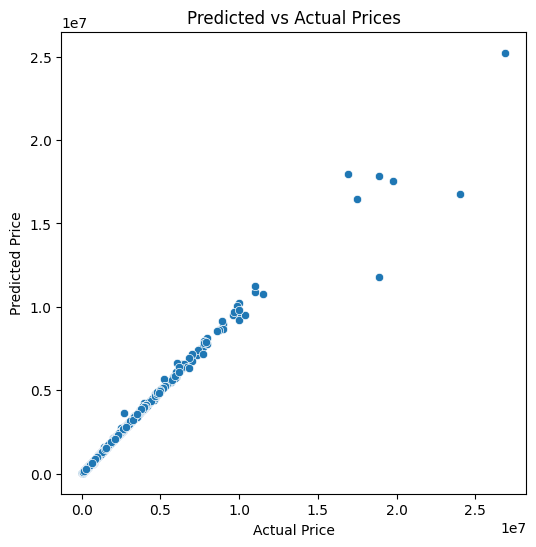

In [11]:
y_pred_test = best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Test MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R²: {r2_test:.2f}")

# Plot Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()
